In [6]:
import tensorflow as tf
import numpy as np
import import_ipynb

from tensorflow import keras
from keras.models import load_model
from dataset_prep import *
from scipy import signal


Using TensorFlow backend.


importing Jupyter notebook from dataset_prep.ipynb


In [7]:
class LUNET:
    def __init__(self, image_size):
        self.image_size = image_size
        self.model = self.UNet()
    
    def down_block(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
        return c, p

    def up_block(self, x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
        us = keras.layers.UpSampling2D((2, 2))(x)
        concat = keras.layers.Concatenate()([us, skip])
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c

    def bottleneck(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c
    
    def UNet(self):
        f = [8, 16, 32, 64, 128, 256]
        inputs = keras.layers.Input((self.image_size, self.image_size, 3))

        p0 = inputs
        #c0, p0 = self.down_block(p00, f[0]) #256 -> 128
        c1, p1 = self.down_block(p0, f[1]) #128 -> 64
        c2, p2 = self.down_block(p1, f[2]) #64 -> 32
        c3, p3 = self.down_block(p2, f[3]) #32 -> 16
        c4, p4 = self.down_block(p3, f[4]) #16->8

        bn = self.bottleneck(p4, f[5])

        u1 = self.up_block(bn, c4, f[4]) #8 -> 16
        u2 = self.up_block(u1, c3, f[3]) #16 -> 32
        u3 = self.up_block(u2, c2, f[2]) #32 -> 64
        u4 = self.up_block(u3, c1, f[1]) #64 -> 128
        #u5 = self.up_block(u4, c0, f[0]) #128 -> 256
        
        outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
        model = keras.models.Model(inputs, outputs)
        return model

In [8]:
parameters_file = "/Users/denyskononenko/Documents/build_proc/saved_models/UNet_params_150_epochs_new_data.h5"

# hyperparameters
epochs = 150
image_size = 128
batch_size = 8
val_datasize = 10

# indices of train images and validation images
train_ids = image_ids[val_datasize:]
valid_ids = image_ids[:val_datasize]


train_gen = DataGenerator(train_ids, PATH_TO_BUILDINGS_TRAININSET, image_size=image_size, batch_size=batch_size)
valid_gen = DataGenerator(valid_ids, PATH_TO_BUILDINGS_TRAININSET, image_size=image_size, batch_size=batch_size)

In [9]:
lunet = LUNET(image_size)
model = lunet.model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

(8, 128, 128, 3) (8, 128, 128, 1)


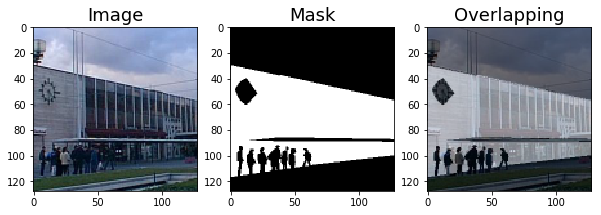

In [11]:
data_gen = DataGenerator(image_ids, PATH_TO_BUILDINGS_TRAININSET)
x, y = data_gen.__getitem__(1)
print(x.shape, y.shape)
DataGenerator.show_img_mask(x[7], y[7])

In [12]:
train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)



Epoch 1/150
24/24 [==============================] - 29s 1s/step - loss: 5.1363 - acc: 0.6472 - val_loss: 4.4316 - val_acc: 0.8007
Epoch 2/150
24/24 [==============================] - 28s 1s/step - loss: 4.9339 - acc: 0.6708 - val_loss: 4.1821 - val_acc: 0.7400
Epoch 3/150
24/24 [==============================] - 29s 1s/step - loss: 4.2199 - acc: 0.7510 - val_loss: 2.8676 - val_acc: 0.8472
Epoch 4/150
24/24 [==============================] - 26s 1s/step - loss: 3.9913 - acc: 0.7566 - val_loss: 3.5352 - val_acc: 0.8223
Epoch 5/150
24/24 [==============================] - 29s 1s/step - loss: 3.6944 - acc: 0.7826 - val_loss: 3.3305 - val_acc: 0.8174
Epoch 6/150
24/24 [==============================] - 27s 1s/step - loss: 3.4681 - acc: 0.7989 - val_loss: 2.7698 - val_acc: 0.8450
Epoch 7/150
24/24 [==============================] - 27s 1s/step - loss: 3.6919 - acc: 0.7779 - val_loss: 3.1755 - val_acc: 0.8327
Epoch 8/150
24/24 [==============================] - 26s 1s/step - loss: 3.4794 - a

Epoch 125/150
24/24 [==============================] - 25s 1s/step - loss: 0.2653 - acc: 0.9771 - val_loss: 5.2062 - val_acc: 0.8681
Epoch 126/150
24/24 [==============================] - 25s 1s/step - loss: 0.2812 - acc: 0.9765 - val_loss: 6.4909 - val_acc: 0.8699
Epoch 127/150
24/24 [==============================] - 25s 1s/step - loss: 0.2731 - acc: 0.9769 - val_loss: 5.8666 - val_acc: 0.8673
Epoch 128/150
24/24 [==============================] - 25s 1s/step - loss: 0.2574 - acc: 0.9777 - val_loss: 6.1779 - val_acc: 0.8645
Epoch 129/150
24/24 [==============================] - 25s 1s/step - loss: 0.2439 - acc: 0.9782 - val_loss: 6.3188 - val_acc: 0.8702
Epoch 130/150
24/24 [==============================] - 25s 1s/step - loss: 0.2502 - acc: 0.9779 - val_loss: 6.0807 - val_acc: 0.8639
Epoch 131/150
24/24 [==============================] - 25s 1s/step - loss: 0.2392 - acc: 0.9784 - val_loss: 6.6459 - val_acc: 0.8684
Epoch 132/150
24/24 [==============================] - 110s 5s/step -

In [13]:
## Save the Weights
model.save_weights(parameters_file)

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x) 

result = result > 0.5

In [12]:
def display_valid_imgs(img, background, result, image_size=128):
    """
    Display init image, background truth and prediction of NN
    """
    plt.figure(figsize=(10, 10))
    
    plt.subplot(131)
    plt.title("init image", fontsize=18)
    plt.imshow(img)
        
    plt.subplot(132)
    plt.title("Background truth", fontsize=18)
    plt.imshow(np.reshape(background, (image_size, image_size)), cmap="gray")
        
    plt.subplot(133)
    plt.title("Result", fontsize=18)
    plt.imshow(np.reshape(result, (image_size, image_size)), cmap="gray")
    
def display_test_imgs(img1, result1, img2, result2, image_size=128):
    """12
    Display init image, background truth and prediction of NN for image pairs
    """
    plt.figure(figsize=(20, 20))
    
    plt.subplot(141)
    plt.title("init image 1", fontsize=18)
    plt.imshow(img1)
        
    plt.subplot(142)
    plt.title("result 1", fontsize=18)
    plt.imshow(np.reshape(result1, (image_size, image_size)), cmap="gray")
        
    plt.subplot(143)
    plt.title("init image 2", fontsize=18)
    plt.imshow(img2)
    
    plt.subplot(144)
    plt.title("result 2", fontsize=18)
    plt.imshow(np.reshape(result2, (image_size, image_size)), cmap="gray")
    

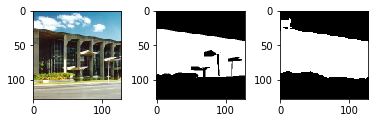

In [15]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[2])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[2]*255, (image_size, image_size)), cmap="gray")

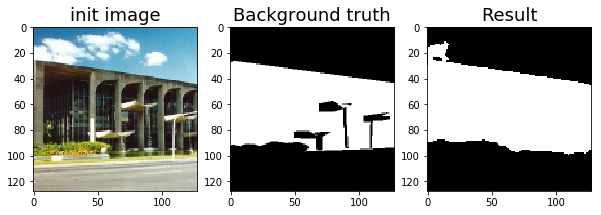

In [16]:
display_valid_imgs(x[2], y[2], result[2])

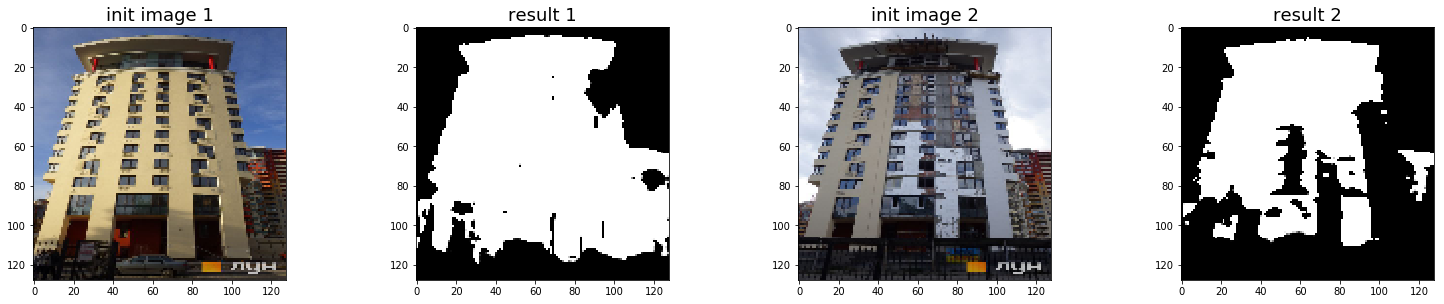

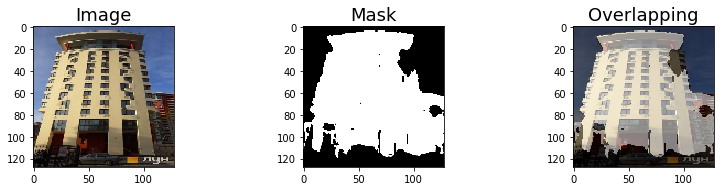

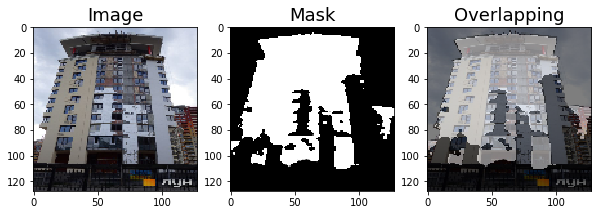

In [39]:
test_images = ["https://img.lun.ua/construction-1600x900/220857.jpg", "https://img.lun.ua/construction-1600x900/179470.jpg", "https://img.lun.ua/construction-1600x900/236157.jpg", "https://img.lun.ua/construction-1600x900/235463.jpg", "https://img.lun.ua/construction-1600x900/230669.jpg", "https://img.lun.ua/construction-1600x900/235462.jpg", "https://img.lun.ua/construction-1600x900/67081.jpg", "https://img.lun.ua/construction-1600x900/49734.jpg", "https://img.lun.ua/construction-1600x900/236483.jpg", "https://img.lun.ua/construction-1600x900/232905.jpg", "https://img.lun.ua/construction-1600x900/140392.jpg", "https://img.lun.ua/construction-1600x900/203614.jpg", "https://img.lun.ua/panorama/1983-3-24.jpg"]

test_img1 = cv2.resize(DataGenerator.read_img(test_images[-6]), (128, 128))
test_img2 = cv2.resize(DataGenerator.read_img(test_images[-5]), (128, 128))

res1 = model.predict(np.array([test_img1]))
res2 = model.predict(np.array([test_img2]))

display_test_imgs(test_img1, res1, test_img2, res2)


DataGenerator.show_img_mask(test_img1, res1)
DataGenerator.show_img_mask(test_img2, res2)


In [1]:
def matcher(msk1, msk2):
    """
    Optimal shape matcher
    @param mask1 binary image mask
    @param mask2 binary image mask
    """
    resgr1 = np.uint8(np.reshape(msk1, (128, 128)))
    resgr2 = np.uint8(np.reshape(msk2, (128, 128)))
    
    canny1 = 255 - cv2.Canny(resgr1, 0, 0)
    canny2 = 255 - cv2.Canny(resgr2, 0, 0)
    
    #display both contours
    plt.imshow(canny1, cmap="gray")
    plt.imshow(canny2, alpha=0.5) 
    
    #cor = signal.correlate2d (canny1, canny2)


In [3]:
#matcher(res1, res2) 

In [10]:
# load model coefitients
lunet2 = LUNET(image_size)
model2 = lunet2.model

In [11]:
model2.load_weights(parameters_file)

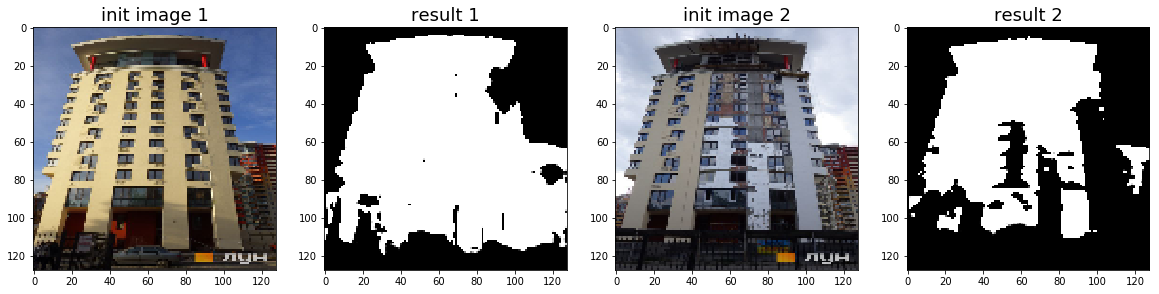

In [14]:
test_images = ["https://img.lun.ua/construction-1600x900/220857.jpg", "https://img.lun.ua/construction-1600x900/179470.jpg", "https://img.lun.ua/construction-1600x900/236157.jpg", "https://img.lun.ua/construction-1600x900/235463.jpg", "https://img.lun.ua/construction-1600x900/230669.jpg", "https://img.lun.ua/construction-1600x900/235462.jpg", "https://img.lun.ua/construction-1600x900/67081.jpg", "https://img.lun.ua/construction-1600x900/49734.jpg", "https://img.lun.ua/construction-1600x900/236483.jpg", "https://img.lun.ua/construction-1600x900/232905.jpg", "https://img.lun.ua/construction-1600x900/140392.jpg", "https://img.lun.ua/construction-1600x900/203614.jpg", "https://img.lun.ua/panorama/1983-3-24.jpg"]

test_img1 = cv2.resize(DataGenerator.read_img(test_images[-7]), (128, 128))
test_img2 = cv2.resize(DataGenerator.read_img(test_images[-6]), (128, 128))

res1 = model2.predict(np.array([test_img1]))
res2 = model2.predict(np.array([test_img2]))

display_test_imgs(test_img1, res1, test_img2, res2)